In [15]:
! pip install langchain langgraph pydantic requests
! pip install -U langchain langchain-openai
! pip install -qU langchain-groq



In [16]:
import os
from getpass import getpass
from datetime import datetime, timedelta
import sqlite3
from typing import Optional, List, Dict

from pydantic import BaseModel, Field
from langchain import PromptTemplate, LLMChain
from langchain.llms.base import LLM
from langchain.schema import HumanMessage, AIMessage, BaseMessage

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import AnyMessage
from langchain_groq import ChatGroq


import requests  # Para realizar llamadas a la API de Groq


In [17]:
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("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")

os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ProyectoAsistenteFinanzauto"


In [18]:
class ChatGroqWrapper:
    def __init__(self, groq_api_key, model_name):
        self.llm = ChatGroq(api_key=groq_api_key, model_name=model_name)
        self.system_prompt = (
            "Eres un asistente virtual útil de Finanzauto. "
            "Tu tarea es asistir a los usuarios proporcionando información y recopilando comentarios. "
            "Cuando interactúes con los usuarios, solicita educadamente la información que necesites, "
            "y nunca proporciones tu propia información personal ni identifiques que eres un asistente virtual."
        )

    def send_message(self, user_id, instruction):
        prompt = f"""{self.system_prompt}

Usuario ID: {user_id}
{instruction}

Asistente:"""
        result = self.llm.invoke(prompt)
        assistant_reply = result.content.strip()
        print(f"Assistant: {assistant_reply}")
        return assistant_reply

In [19]:
llm = ChatGroqWrapper(groq_api_key=os.environ['GROQ_API_KEY'], model_name="llama3-70b-8192")

In [20]:
class UserData(BaseModel):
    user_id: str
    appointment_details_step: int = 0
    conversation_active: bool = True
    credit_number: Optional[str] = None
    first_name: Optional[str] = None
    last_name: Optional[str] = None
    phone_number: Optional[str] = None
    selected_slot: Optional[str] = None
    reason: Optional[str] = None
    available_slots: List[str] = []
    messages: List[AnyMessage] = Field(default_factory=list)

class State(BaseModel):
    user_data: UserData
    messages: List[AnyMessage] = Field(default_factory=list)
    current_node: Optional[str] = None

    def add_message(self, message: AnyMessage):
        self.messages.append(message)
        self.user_data.messages.append(message)



In [21]:
def init_db():
    conn = sqlite3.connect('citas.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS citas (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id TEXT,
            credit_number TEXT,
            first_name TEXT,
            last_name TEXT,
            phone_number TEXT,
            reason TEXT,
            appointment_datetime TEXT
        )
    ''')
    conn.commit()
    conn.close()


In [22]:
def save_appointment(user_data: UserData):
    conn = sqlite3.connect('citas.db')
    cursor = conn.cursor()
    cursor.execute('''
        INSERT INTO citas (
            user_id, credit_number, first_name, last_name,
            phone_number, reason, appointment_datetime
        ) VALUES (?, ?, ?, ?, ?, ?, ?)
    ''', (
        user_data.user_id,
        user_data.credit_number,
        user_data.first_name,
        user_data.last_name,
        user_data.phone_number,
        user_data.reason,
        user_data.selected_slot
    ))
    conn.commit()
    conn.close()


In [23]:
def detect_intent_schedule_appointment(user_input: str) -> bool:
    triggers = ["agendar una cita", "quiero hablar con una persona", "programar cita", "hablar con un asesor"]
    return any(trigger in user_input.lower() for trigger in triggers)


In [24]:
# Crear el grafo
memory = MemorySaver()
graph = StateGraph(State)

# Definir los nodos del grafo
@graph.add_node
def inicio(state: State):
    instruction = "¡Hola! Soy tu asistente virtual de Finanzauto. ¿En qué puedo ayudarte hoy?"
    prompt_template = PromptTemplate(
        input_variables=[],
        template=instruction
    )
    chain = LLMChain(
        llm=llm,
        prompt=prompt_template
    )
    assistant_reply = chain.run()
    state.add_message(AIMessage(content=assistant_reply))
    return "esperar_input"

@graph.add_node
def esperar_input(state: State):
    if state.messages:
        user_input = state.messages[-1].content
    else:
        user_input = ""
    if detect_intent_schedule_appointment(user_input):
        return "mostrar_horarios"
    else:
        instruction = "Entiendo. Para poder ayudarte mejor, ¿podrías proporcionar más detalles?"
        prompt_template = PromptTemplate(
            input_variables=[],
            template=instruction
        )
        chain = LLMChain(
            llm=llm,
            prompt=prompt_template
        )
        assistant_reply = chain.run()
        state.add_message(AIMessage(content=assistant_reply))
        return "esperar_input"

@graph.add_node
def mostrar_horarios(state: State):
    now = datetime.now()
    available_slots = []
    start_time = now + timedelta(hours=2)
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    if start_time.hour < 8:
        start_time = start_time.replace(hour=8)
    elif start_time.hour >= 18:
        start_time = start_time + timedelta(days=1)
        start_time = start_time.replace(hour=8)
    end_time = start_time.replace(hour=18)
    current_time = start_time
    while current_time < end_time:
        if current_time.weekday() < 5:  # Solo días de semana
            slot_str = current_time.strftime('%Y-%m-%d %H:%M')
            available_slots.append(slot_str)
        current_time += timedelta(minutes=20)
    instruction = "Estos son los horarios disponibles para agendar su cita:\n"
    for idx, slot in enumerate(available_slots):
        instruction += f"{idx+1}. {slot}\n"
    instruction += "Por favor, ingrese el número correspondiente al horario que prefiera."
    prompt_template = PromptTemplate(
        input_variables=[],
        template=instruction
    )
    chain = LLMChain(
        llm=llm,
        prompt=prompt_template
    )
    assistant_reply = chain.run()
    state.add_message(AIMessage(content=assistant_reply))
    state.user_data.available_slots = available_slots
    return "esperar_seleccion_horario"

@graph.add_node
def esperar_seleccion_horario(state: State):
    user_input = state.messages[-1].content.strip()
    if user_input.isdigit():
        slot_index = int(user_input) - 1
        if 0 <= slot_index < len(state.user_data.available_slots):
            state.user_data.selected_slot = state.user_data.available_slots[slot_index]
            state.user_data.appointment_details_step = 0
            return "recopilar_datos_cita"
        else:
            instruction = "Selección inválida. Por favor, seleccione un número de la lista de horarios disponibles."
    else:
        instruction = "Por favor, ingrese el número correspondiente al horario que desea."
    prompt_template = PromptTemplate(
        input_variables=[],
        template=instruction
    )
    chain = LLMChain(
        llm=llm,
        prompt=prompt_template
    )
    assistant_reply = chain.run()
    state.add_message(AIMessage(content=assistant_reply))
    return "esperar_seleccion_horario"

@graph.add_node
def recopilar_datos_cita(state: State):
    steps = [
        "Para confirmar su cita, por favor proporcione su número de crédito.",
        "Ahora, por favor, indique su nombre.",
        "Por favor, indique su apellido.",
        "Proporcione su número de teléfono.",
        "Finalmente, indique el motivo de la cita."
    ]
    step = state.user_data.appointment_details_step
    if step < len(steps):
        instruction = steps[step]
        prompt_template = PromptTemplate(
            input_variables=[],
            template=instruction
        )
        chain = LLMChain(
            llm=llm,
            prompt=prompt_template
        )
        assistant_reply = chain.run()
        state.add_message(AIMessage(content=assistant_reply))
        return "esperar_datos_cita"
    else:
        save_appointment(state.user_data)
        instruction = f"Su cita ha sido agendada para el {state.user_data.selected_slot}. Un asesor del equipo ZAC se pondrá en contacto con usted."
        prompt_template = PromptTemplate(
            input_variables=[],
            template=instruction
        )
        chain = LLMChain(
            llm=llm,
            prompt=prompt_template
        )
        assistant_reply = chain.run()
        state.add_message(AIMessage(content=assistant_reply))
        return "fin_conversacion"

@graph.add_node
def esperar_datos_cita(state: State):
    user_input = state.messages[-1].content.strip()
    step = state.user_data.appointment_details_step
    if step == 0:
        state.user_data.credit_number = user_input
    elif step == 1:
        state.user_data.first_name = user_input
    elif step == 2:
        state.user_data.last_name = user_input
    elif step == 3:
        state.user_data.phone_number = user_input
    elif step == 4:
        state.user_data.reason = user_input
    state.user_data.appointment_details_step += 1
    return "recopilar_datos_cita"

@graph.add_node
def fin_conversacion(state: State):
    instruction = "¿Hay algo más en lo que pueda ayudarte?"
    prompt_template = PromptTemplate(
        input_variables=[],
        template=instruction
    )
    chain = LLMChain(
        llm=llm,
        prompt=prompt_template
    )
    assistant_reply = chain.run()
    state.add_message(AIMessage(content=assistant_reply))
    return "esperar_respuesta_final"

@graph.add_node
def esperar_respuesta_final(state: State):
    user_input = state.messages[-1].content.lower()
    if "no" in user_input or "gracias" in user_input:
        instruction = "Gracias por comunicarte con Finanzauto. ¡Que tengas un excelente día!"
        prompt_template = PromptTemplate(
            input_variables=[],
            template=instruction
        )
        chain = LLMChain(
            llm=llm,
            prompt=prompt_template
        )
        assistant_reply = chain.run()
        state.add_message(AIMessage(content=assistant_reply))
        state.user_data.conversation_active = False
        return END
    else:
        instruction = "Entiendo. Por favor, indícame en qué más puedo ayudarte."
        prompt_template = PromptTemplate(
            input_variables=[],
            template=instruction
        )
        chain = LLMChain(
            llm=llm,
            prompt=prompt_template
        )
        assistant_reply = chain.run()
        state.add_message(AIMessage(content=assistant_reply))
        return "esperar_respuesta_final"


In [25]:
graph.add_edge(START, "inicio")
graph.add_edge("inicio", "esperar_input")
graph.add_edge("esperar_input", "esperar_input")  # Se mantiene en esperar_input hasta detectar intención
graph.add_edge("esperar_input", "mostrar_horarios")
graph.add_edge("mostrar_horarios", "esperar_seleccion_horario")
graph.add_edge("esperar_seleccion_horario", "recopilar_datos_cita")
graph.add_edge("esperar_seleccion_horario", "esperar_seleccion_horario")  # Para entradas inválidas
graph.add_edge("recopilar_datos_cita", "esperar_datos_cita")
graph.add_edge("esperar_datos_cita", "recopilar_datos_cita")
graph.add_edge("recopilar_datos_cita", "fin_conversacion")
graph.add_edge("fin_conversacion", "esperar_respuesta_final")
graph.add_edge("esperar_respuesta_final", "fin_conversacion")
graph.add_edge("esperar_respuesta_final", END)

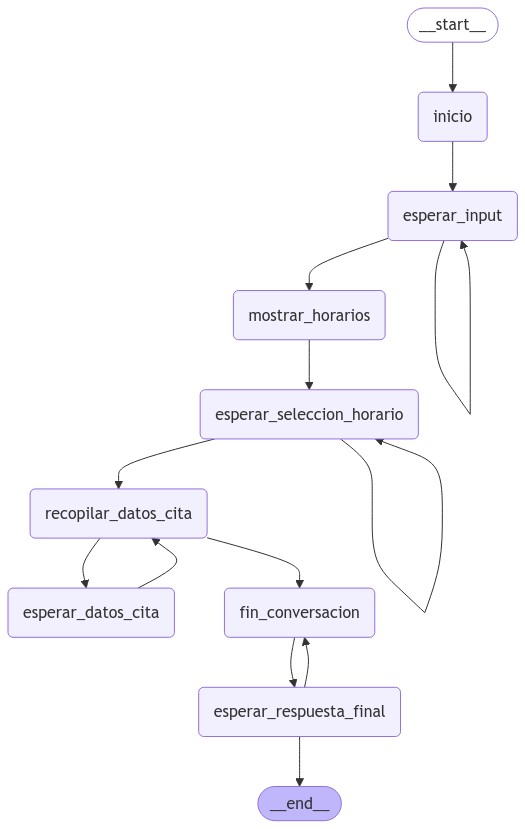

In [26]:
compiled_graph = graph.compile(checkpointer=memory)

compiled_graph.get_graph().draw_mermaid_png(output_file_path="graph.png")

try:
    from IPython.display import Image, display
    display(Image("graph.png"))
except ImportError:
    print("No se puede mostrar la imagen del grafo en este entorno.")


In [27]:
def run_graph(user_id: str):
    init_db()
    user_data = UserData(user_id=user_id)
    state = State(user_data=user_data)
    config = {"configurable": {"thread_id": user_id}}

    # Iniciar la conversación agregando el mensaje inicial
    # Este mensaje simula la entrada del usuario para iniciar la conversación
    state.add_message(HumanMessage(content="Inicio de la conversación"))

    while state.user_data.conversation_active:
        try:
            outputs = compiled_graph.invoke(input=state, config=config)
            state = outputs.state  # Actualizar el estado
        except Exception as e:
            print(f"Error al ejecutar el grafo: {e}")
            break

        # Mostrar el último mensaje del asistente
        if state.messages:
            last_message = state.messages[-1]
            if isinstance(last_message, AIMessage):
                print(f"Asistente: {last_message.content}")

        if not state.user_data.conversation_active:
            break

        # Solicitar entrada del usuario
        user_input = input("Usuario: ")
        if not user_input.strip():
            continue
        # Agregar el mensaje del usuario al estado
        state.add_message(HumanMessage(content=user_input))


In [29]:
if __name__ == "__main__":
    user_id = "usuario_123"
    run_graph(user_id)

Error al ejecutar el grafo: 2 validation errors for LLMChain
llm.is-instance[Runnable]
  Input should be an instance of Runnable [type=is_instance_of, input_value=<__main__.ChatGroqWrapper...t at 0x0000020CFB5D5BE0>, input_type=ChatGroqWrapper]
    For further information visit https://errors.pydantic.dev/2.9/v/is_instance_of
llm.is-instance[Runnable]
  Input should be an instance of Runnable [type=is_instance_of, input_value=<__main__.ChatGroqWrapper...t at 0x0000020CFB5D5BE0>, input_type=ChatGroqWrapper]
    For further information visit https://errors.pydantic.dev/2.9/v/is_instance_of
